# 4. Modelowanie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# statystyki, metryki
from statistics import mean, stdev
from sklearn.metrics import roc_auc_score
from sklearn import metrics

## Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# podział zbioru
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

# modele
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# optymalizacja
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# from sklearn.exceptions import DataConversionWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
df_x = pd.read_csv("Loan_data_no_outliers_x_stand.csv")
df_y = pd.read_csv("Loan_data_y.csv")

## Klasteryzacja (analiza skupień)

- metoda k-średnich - K-means
- hierarchiczna analiza skupień (HCA),
- DBSCAN (tez może służyć do wyodrębniania obserwacji odstających)
- algorytm oczekiwanie-maksymalizacja,

### K-means

Określam optymalną liczbę klastrów

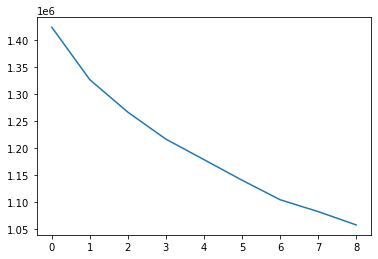

In [4]:
#  metoda 1: metoda łokcia (elbow curve)
ssd = [] # suma kwadratów odległości
range_n_clusters = [*range(2,11)]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(df_x)
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)
plt.show()

Z powyższego wykresu wynika, że optymalną liczbą klastrów jest 3, 5 lub 8 (po uwzględnieniu przesunięcia w skali, która jest od 0 do 8)

In [5]:
# metoda 2: Miara wewnętrzna - wskaźnik sylwetkowy
range_n_clusters = [*range(2,11)]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(df_x)
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df_x, cluster_labels)
    print(f"For {num_clusters}, the silhouette score is {silhouette_avg}")

For 2, the silhouette score is 0.14597004084168547
For 3, the silhouette score is 0.10539044881836486
For 4, the silhouette score is 0.08963799846385762
For 5, the silhouette score is 0.09359012075014067
For 6, the silhouette score is 0.08334518684804196
For 7, the silhouette score is 0.08335128064793626
For 8, the silhouette score is 0.08976666789285914
For 9, the silhouette score is 0.08052841431488109
For 10, the silhouette score is 0.07905681032689309


Według wskaźnika sylwetkowego optymalna liczba klastrów to 2, 3 lub 5.
Wybieram więc 3 klastry.

In [6]:
# liczba klastrów n = 3
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(df_x)

KMeans(max_iter=1000, n_clusters=3)

In [7]:
# dodaję zmienną z wynikiem podziału na klastry do zbioru
df_x['kmeans_cluster_3'] = pd.DataFrame(kmeans.labels_).copy()

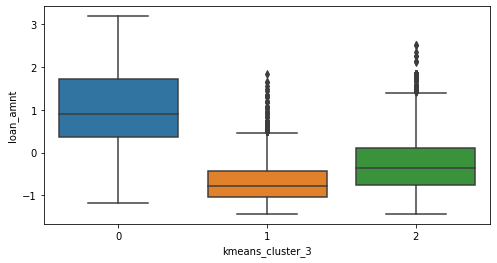

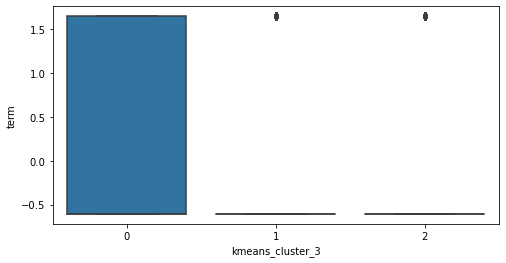

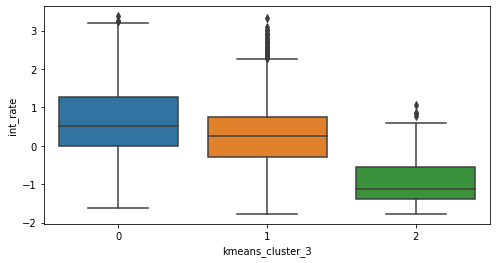

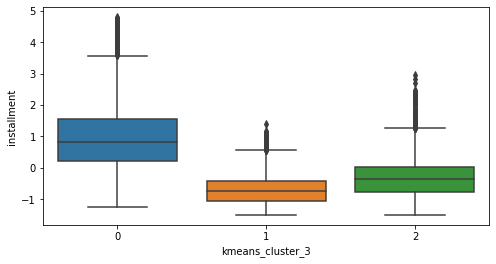

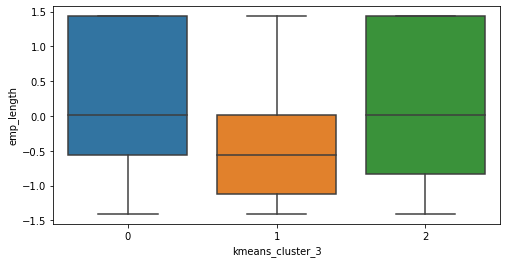

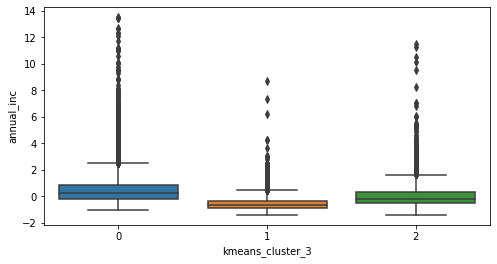

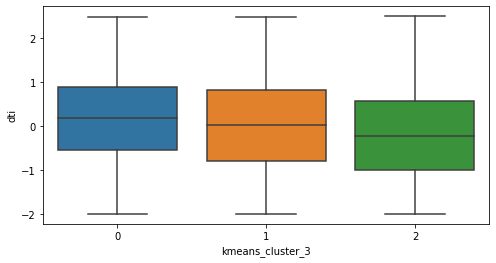

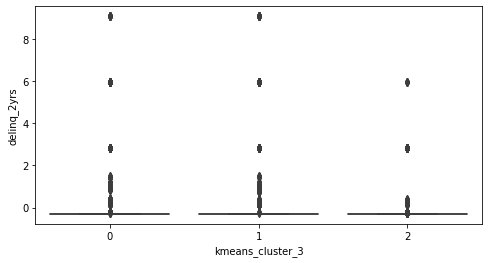

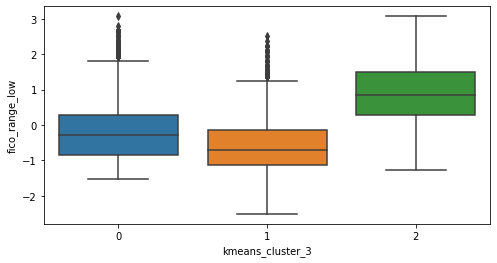

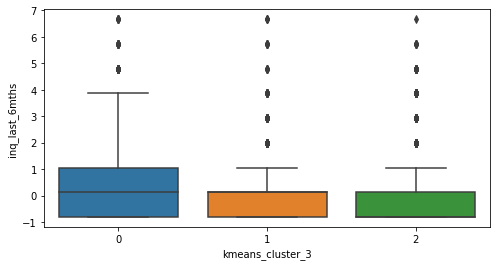

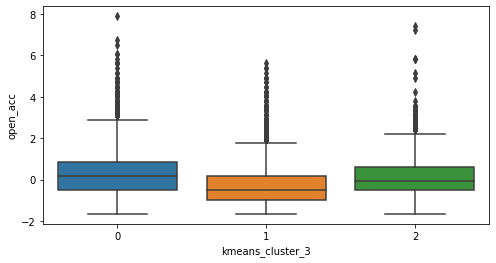

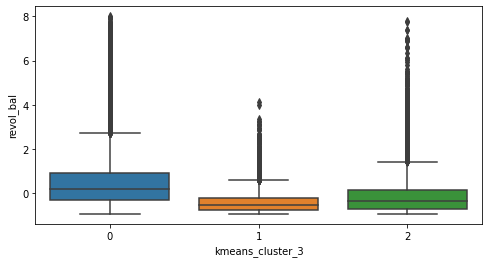

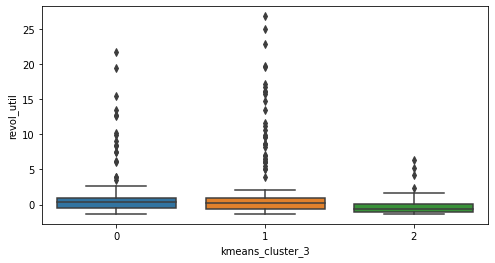

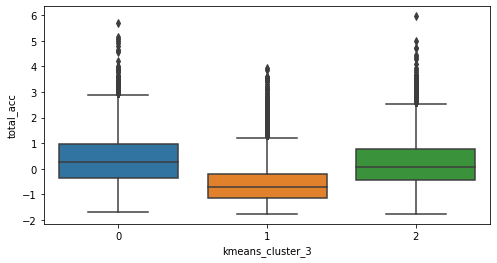

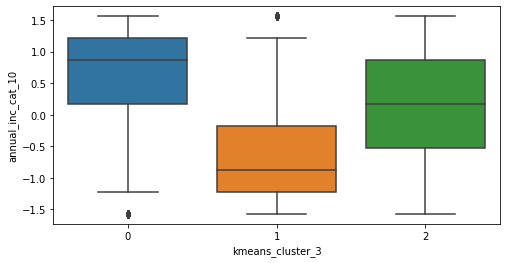

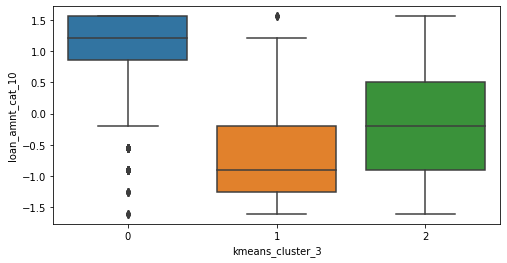

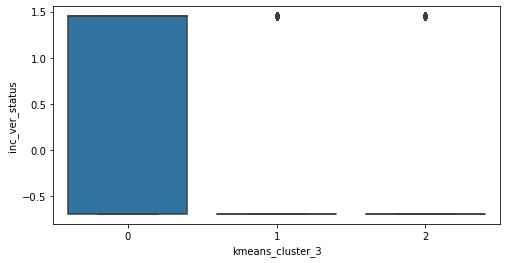

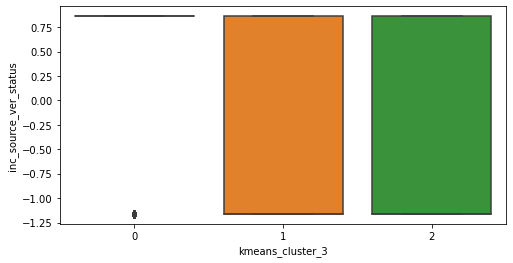

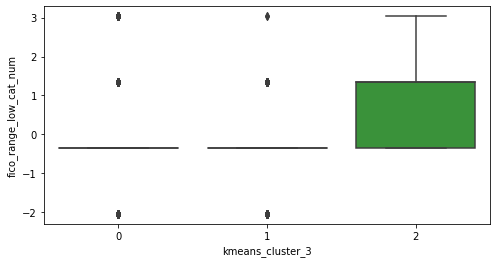

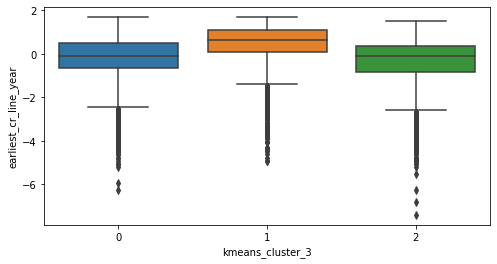

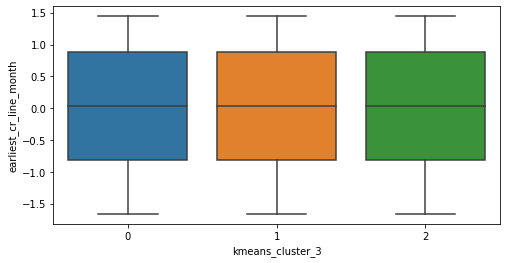

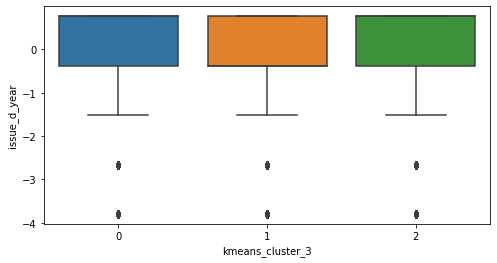

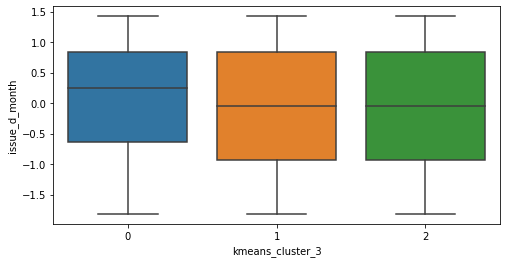

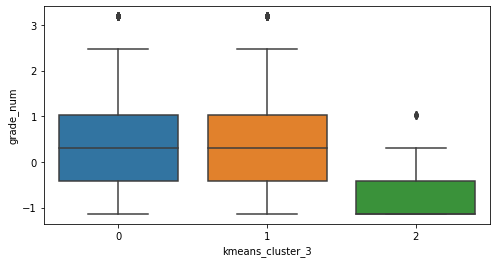

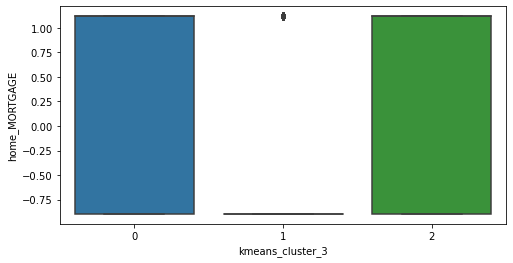

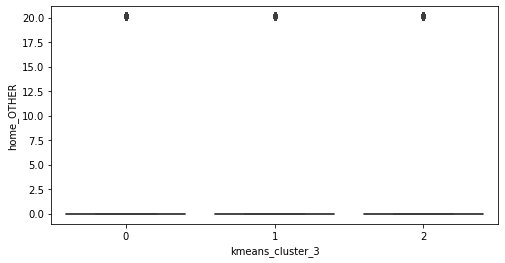

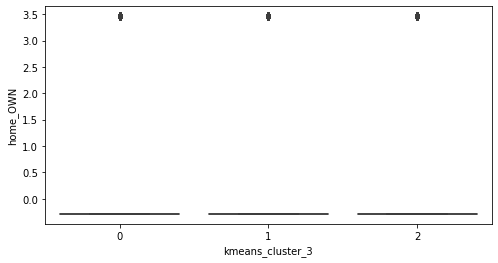

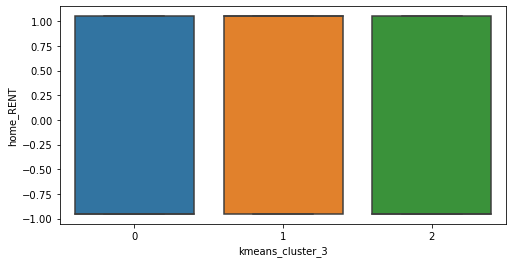

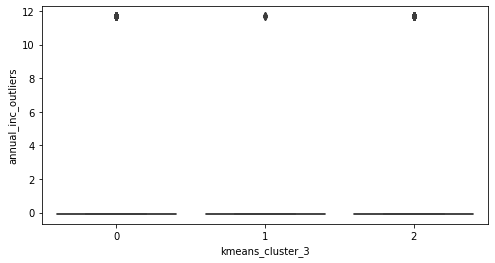

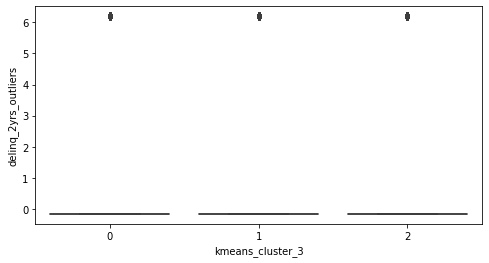

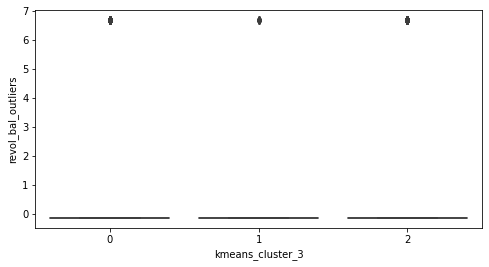

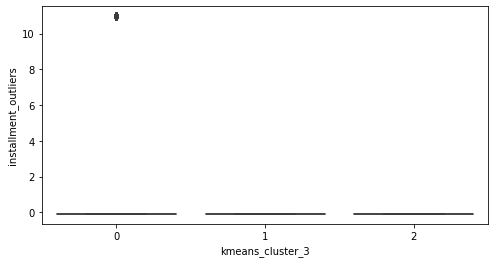

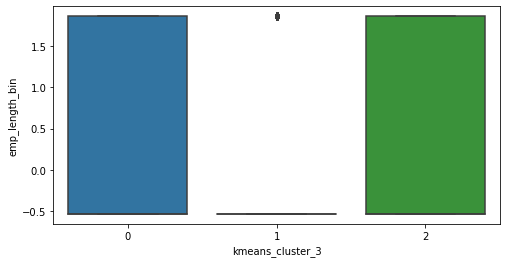

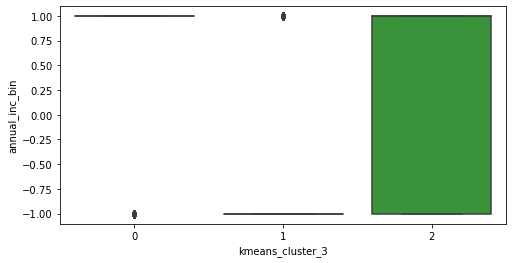

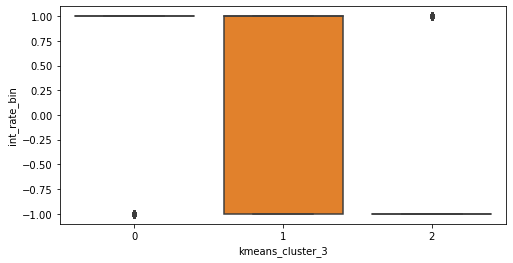

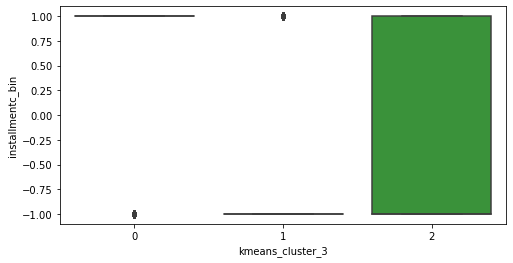

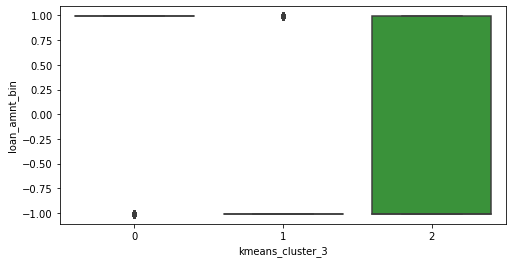

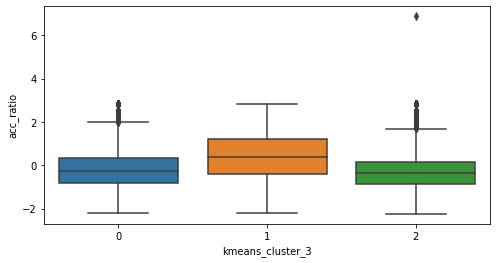

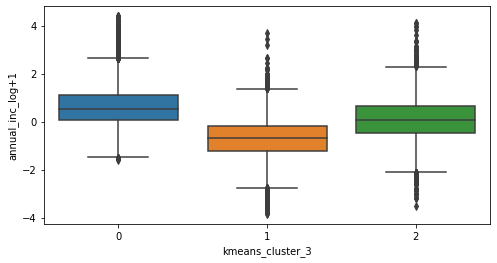

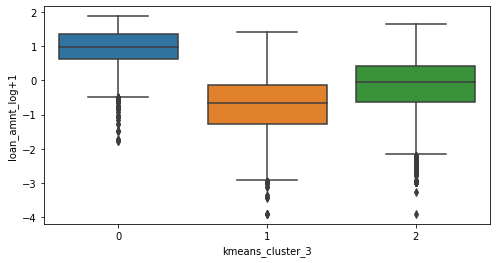

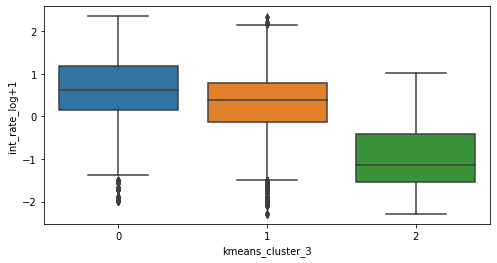

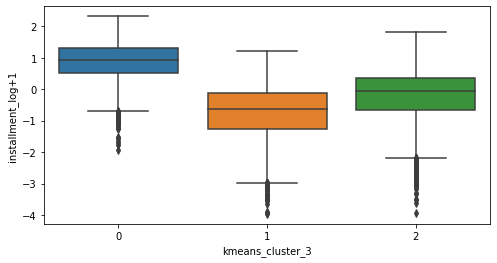

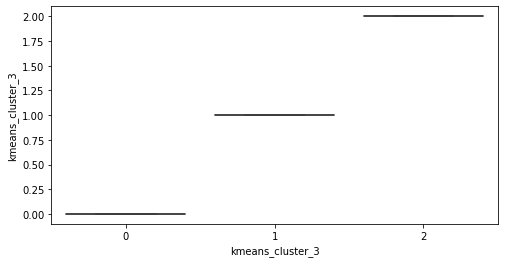

In [8]:
for column in df_x.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='kmeans_cluster_3', y=column, data=df_x)

Zmienne, które rozróżniają te obserwacje to są: wysokość kwoty pożyczki, oprocentowanie, rata, długość zatrudnienia, dochód, fico score,
dochód kategoryzowany, wysokość kwoty pożyczki kategoryzowana, 

Mniej wyraźnie: term, revol_bal, total_acc, inc_ver_status, inc_ver_source_status,
earliest_cr_line_year, grade_num, home_Mortgage

a także zmienne binarne stworzone z powyższych zmiennych.

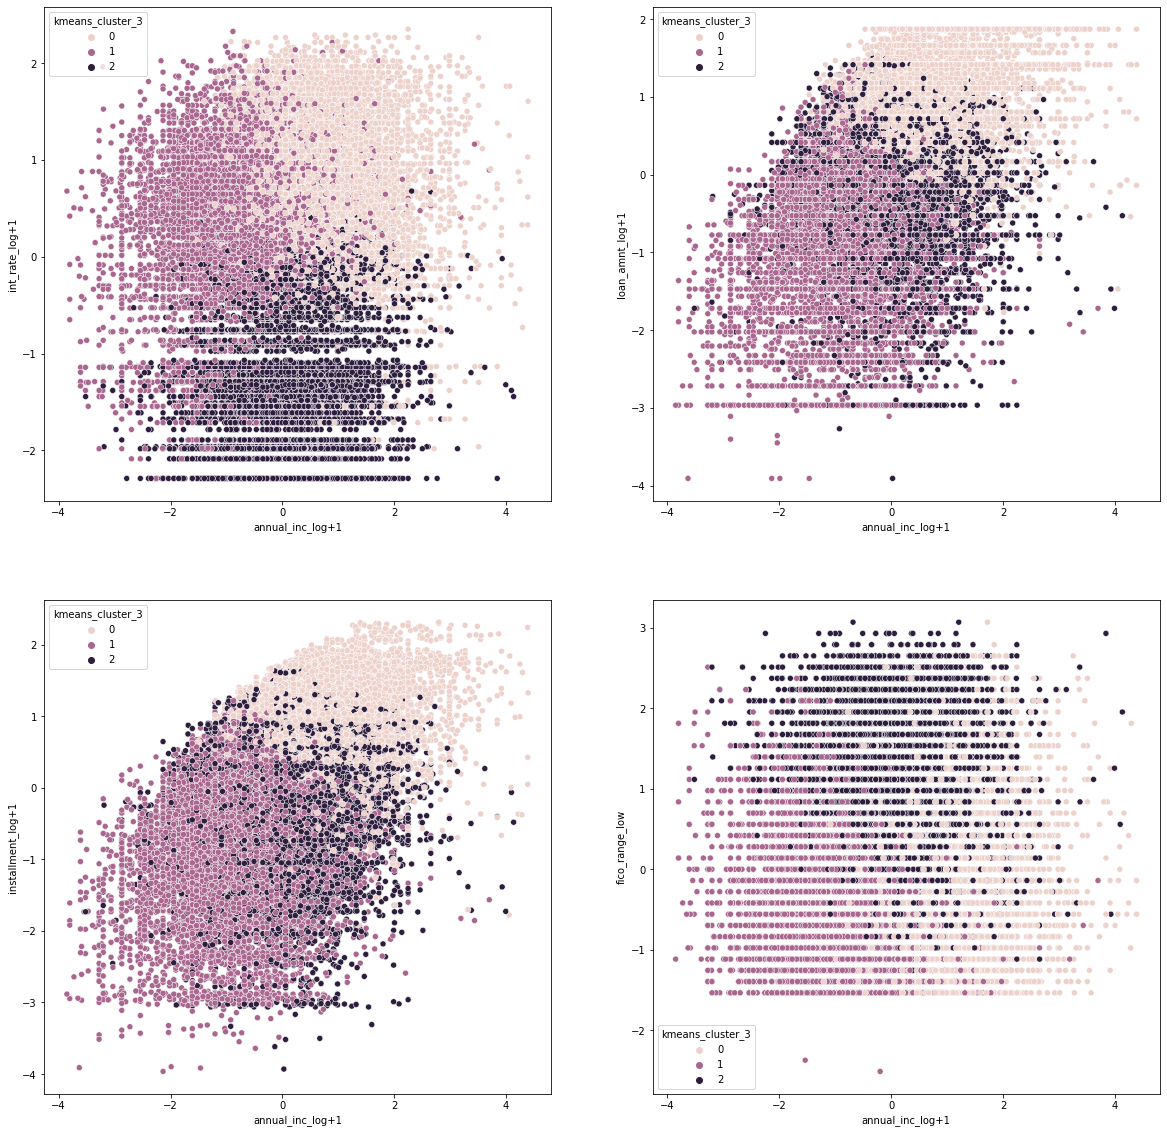

In [10]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.scatterplot(x='annual_inc_log+1',y='int_rate_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,2)
sns.scatterplot(x='annual_inc_log+1',y='loan_amnt_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,3)
sns.scatterplot(x='annual_inc_log+1',y='installment_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,4)
sns.scatterplot(x='annual_inc_log+1',y='fico_range_low',data=df_x,hue='kmeans_cluster_3')

plt.show()

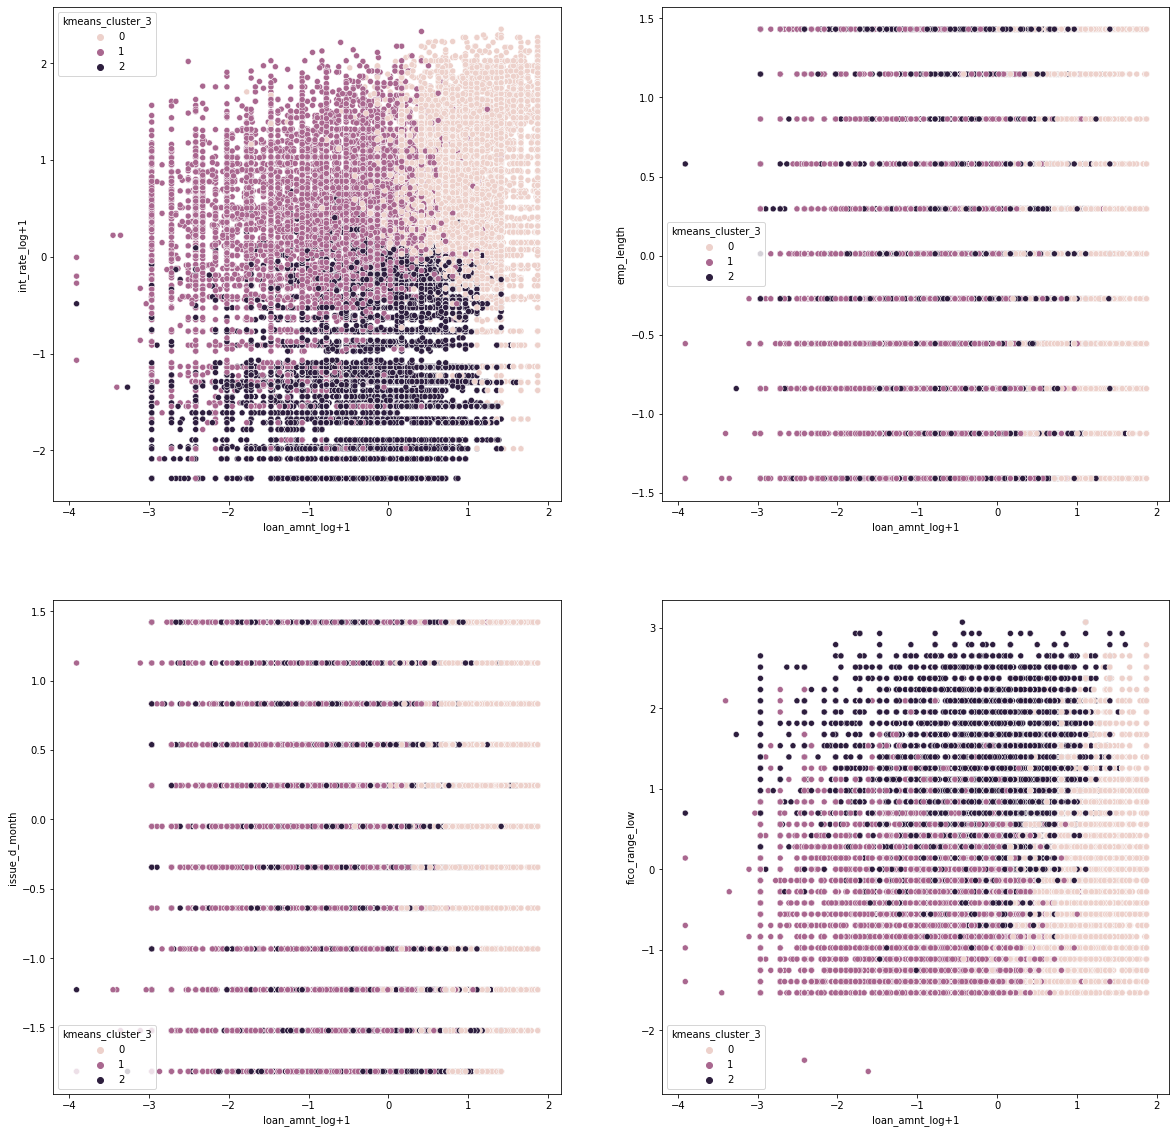

In [11]:
plt.figure(figsize=(20,20)) #,dpi=200

plt.subplot(2,2,1)
sns.scatterplot(x='loan_amnt_log+1',y='int_rate_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,2)
sns.scatterplot(x='loan_amnt_log+1',y = 'emp_length',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,3)
sns.scatterplot(x='loan_amnt_log+1',y='issue_d_month',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,4)
sns.scatterplot(x='loan_amnt_log+1',y='fico_range_low',data=df_x,hue='kmeans_cluster_3')

plt.show()

Podsumowanie - komentarz:

- 0: wysoki dochód, wysokie oprocentowanie, wysoka kwota kredytu, niski/średni fico score, długie zatrudnienie -> średnie/większe ryzyko
- 1: niski dochód, średnie oprocentowanie, niska kwota kredytu, niski fico score, krótkie zatrudnienie -> większe ryzyko
- 2: średni dochód, niskie oprocentowanie, średnia kwita kredytu, wysoki fico score, długie zatrudnienie -> niższe ryzyko

Sprawdźmy te przypuszczenia:

In [12]:
df_all = pd.concat([df_x, df_y], axis=1)

In [13]:
df_all.groupby('kmeans_cluster_3')['target'].mean()

kmeans_cluster_3
0    0.821745
1    0.830680
2    0.925950
Name: target, dtype: float64

Przypuszczenia się sprawdziły. Najniższy odsetek niespłacających jest w klastrze 2, najwyższy w klastrze 0, i odrobinę wyższy w klastrze 1. Czyli pod względem prawdopodobieństwa niespłacenia długu odrożnia się klaster 2, w którym jest ono najmniejsze. 

### Hierarchical clustering

Druga metoda klastrowania. Tą metodę było mi trudno przeprowadzic na całym zbiorze, ze względu na moc obliczeniową. Dlatego zdecydowałam wykonać ją na zbiorze ograniczonym - wyodrębniłam część zmiennych najbardzirj różnicujących zbiór według metody K-means.

In [ ]:
hc_vars = ['int_rate_log+1', 'installment_log+1', 'emp_length', 'fico_range_low', 'revol_bal', 'annual_inc_log+1',
           'loan_amnt_log+1', 'grade_num', 'term', 'emp_length_bin', 'int_rate_bin', 'annual_inc_bin', 'installmentc_bin',
          'loan_amnt_bin']

In [ ]:
df_hc = df_x[hc_vars]

In [ ]:
sl_mergings = linkage(df_hc)
dendrogram(sl_mergings)
plt.show()

Niestety również i ten sposób nie pomógł (komunikat "The kernel appears to have died. It will restart automatically" ale niestety to się nie dzieje), więc zostawiam ten algorytm.

### DBSCAN

In [14]:
dbscan_classifier = DBSCAN()
dbscan_classifier.fit(df_x)

DBSCAN()

In [15]:
n_clusters = len(set(dbscan_classifier.labels_)) - (1 if -1 in dbscan_classifier.labels_ else 0)
n_noise = list(dbscan_classifier.labels_).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 0
Estimated number of noise points: 39786


Algorytm nie znajduje żadnego klastra. Wobec tego szukam optymalnych parametrów.

In [16]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_x)
distances, indices = nbrs.kneighbors(df_x)

In [17]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

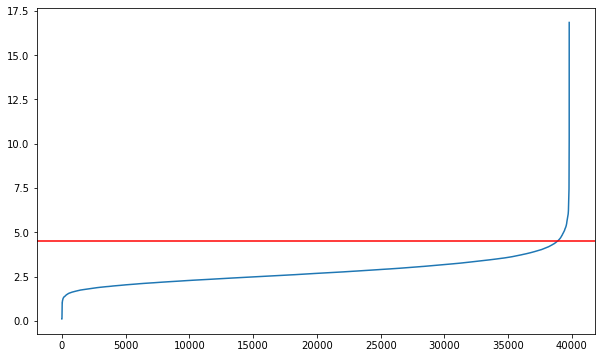

In [18]:
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.axhline(y = 4.5, color = 'r', linestyle = '-')
plt.show()

Na tym wykresie szukam przegięcia - tam znajduje się optymalna odległość epsilon - w tym wypadku wynosi ona ok 5.

In [19]:
dbscan_classifier = DBSCAN(eps=5)
dbscan_model = dbscan_classifier.fit(df_x)

In [20]:
n_clusters = len(set(dbscan_classifier.labels_)) - (1 if -1 in dbscan_classifier.labels_ else 0)
n_noise = list(dbscan_classifier.labels_).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 16
Estimated number of noise points: 600


To jest dość sporo klastrów, ale jednocześnie wiem, że zbiór jest spory i może być różnorodny. Zobaczmy, w jaki sposób DBSCAN go podzielił.

In [21]:
df_x['dbscan_cluster'] = pd.DataFrame(dbscan_classifier.labels_).copy()

Teraz chcę zwizualizować podział na klastry dokonany przez DBSCAN. W tym celu wykonuję redukcję wymiarów t-SNE, dopisuję dwa wymiary do źródłowego dataframe'a, i wyświetlam wyniki na wykresie punktowym.

In [23]:
from sklearn.manifold import TSNE

x_tsne_array = TSNE(n_components=2).fit_transform(df_x)

In [24]:
df_x["tsne_x_component"] = x_tsne_array[:,0]
df_x["tsne_y_component"] = x_tsne_array[:,1]

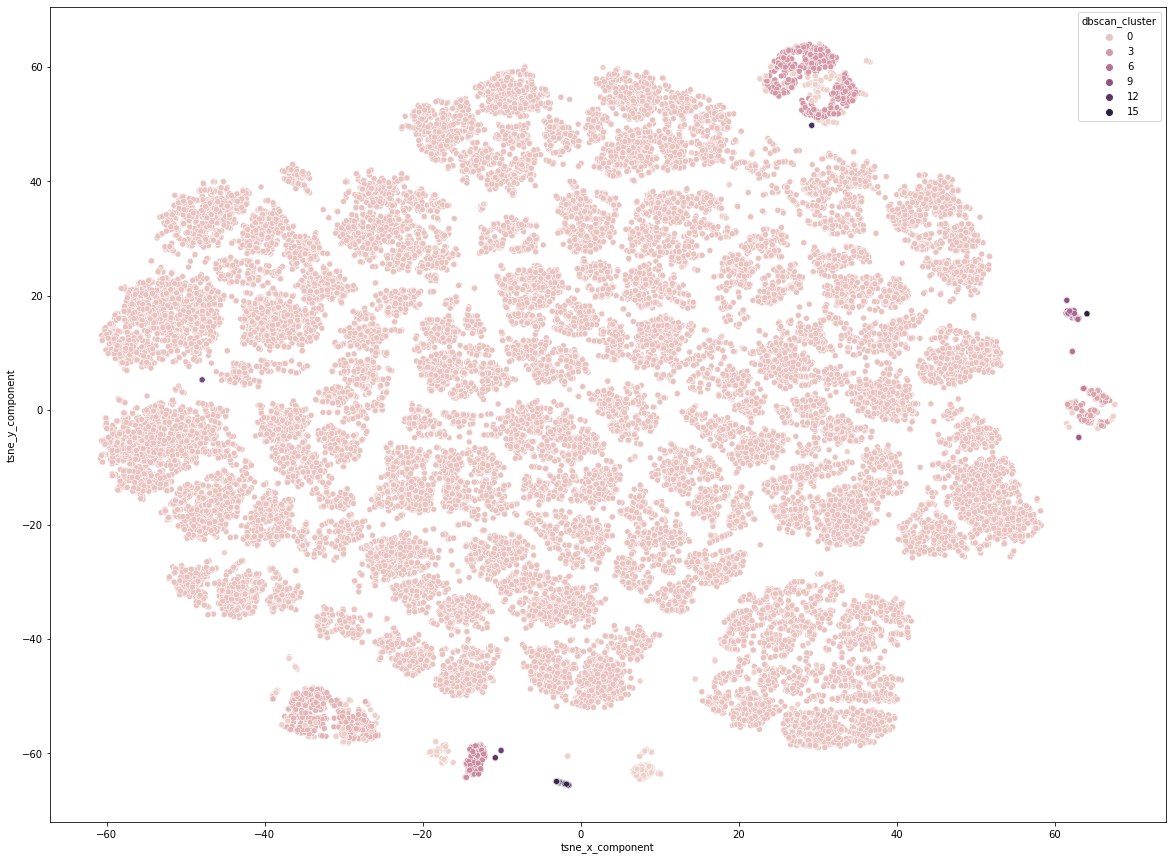

In [25]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='tsne_x_component',y='tsne_y_component',data=df_x,hue='dbscan_cluster')
plt.show()

In [26]:
df_x['dbscan_cluster'].value_counts()

 0     37223
 3       674
 1       639
-1       600
 2       251
 4       189
 7        80
 14       69
 9        13
 8        11
 11        6
 15        6
 10        5
 13        5
 12        5
 6         5
 5         5
Name: dbscan_cluster, dtype: int64

Najwidoczniej grupa klientów nie dzieli się na wyraźne podgrupy, zdecydowana większość znajduje się w jednym klastrze, jest także sporo klastrów z pojedynczymi obserwacjami.

In [27]:
# ponieważ cały dataset jest wystandaryzowany, a nowo dodane zmienne z klasteryzacji nie, to standaryzuję je też
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_new_vars = df_x[['kmeans_cluster_3', 'tsne_x_component', 'tsne_y_component']].copy()
scaled_x_array = scaler.fit_transform(df_new_vars)
df_new_vars = pd.DataFrame(scaled_x_array,columns=df_new_vars.columns) 

df_x[['kmeans_cluster_3', 'tsne_x_component', 'tsne_y_component']] = df_new_vars

In [28]:
df_x.to_csv('Loan_data_x_after_unsupervised.csv', index=False)

In [ ]:
# df_x = pd.read_csv('Loan_data_x_after_unsupervised_v2.csv')
# df_y = pd.read_csv("Loan_data_y_v2.csv")

## Uczenie nadzorowane

In [30]:
df_x[sorted(df_x)].columns.tolist()

['acc_ratio',
 'annual_inc',
 'annual_inc_bin',
 'annual_inc_cat_10',
 'annual_inc_log+1',
 'annual_inc_outliers',
 'dbscan_cluster',
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low',
 'fico_range_low_cat_num',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment',
 'installment_log+1',
 'installment_outliers',
 'installmentc_bin',
 'int_rate',
 'int_rate_bin',
 'int_rate_log+1',
 'issue_d_month',
 'issue_d_year',
 'kmeans_cluster_3',
 'loan_amnt',
 'loan_amnt_bin',
 'loan_amnt_cat_10',
 'loan_amnt_log+1',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 'tsne_x_component',
 'tsne_y_component']

In [31]:
# pierwszy zestaw predyktorów - zmienne wyjściowe
predictors_orig = [
'acc_ratio',
 'annual_inc',
 'annual_inc_bin',
 'annual_inc_outliers',
 'dbscan_cluster',
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment',
 'installment_outliers',
 'installmentc_bin',
 'int_rate',
 'int_rate_bin',
 'issue_d_month',
 'issue_d_year',
 'kmeans_cluster_3',
 'loan_amnt', 
 'loan_amnt_bin',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 'tsne_x_component',
 'tsne_y_component'
]

In [32]:
# drugi zestaw predyktorów - logarytmowane
predictors_log = [
'acc_ratio',
 'annual_inc_bin', 
'annual_inc_log+1',
 'annual_inc_outliers',
 'dbscan_cluster',
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment_log+1',
 'installment_outliers',
 'installmentc_bin',
 'int_rate', 'int_rate_log+1',
 'int_rate_bin',
 'issue_d_month',
 'issue_d_year',
 'kmeans_cluster_3',
 'loan_amnt_log+1',
 'loan_amnt_bin',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 'tsne_x_component',
 'tsne_y_component'
]

In [33]:
# trzeci zestaw - zmienne kategoryzowane
predictors_cat = [
 'acc_ratio',
 'annual_inc_bin',
 'annual_inc_cat_10',
 'annual_inc_outliers',
 'dbscan_cluster',
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low_cat_num',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment',
 'installment_outliers',
 'installmentc_bin',
 'int_rate',
 'int_rate_bin',
 'issue_d_month',
 'issue_d_year',
 'kmeans_cluster_3',
 'loan_amnt_cat_10',
 'loan_amnt_bin',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 'tsne_x_component',
 'tsne_y_component'
]

In [34]:
df_x = df_x[predictors_log]

### 1. Regresja Logistyczna

In [35]:
LogisticRegr_1 = LogisticRegression(max_iter=500)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LogisticRegr_1.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LogisticRegr_1.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean)*100, 3), '%')

List of aurocs: [0.7032757091373739, 0.6925117491745081, 0.7221886236149619, 0.6779227170004818, 0.694937568618694, 0.6597660296370731, 0.6823545774977418, 0.6846911408623517, 0.6842893905338936, 0.6873901585129965]

Mean AUROC: 68.893 %


In [36]:
results = pd.DataFrame({'Method':['Log Reg StratifiedKFold'], 'ROC AUC score': round(auroc_mean,3)},index=['1'])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689


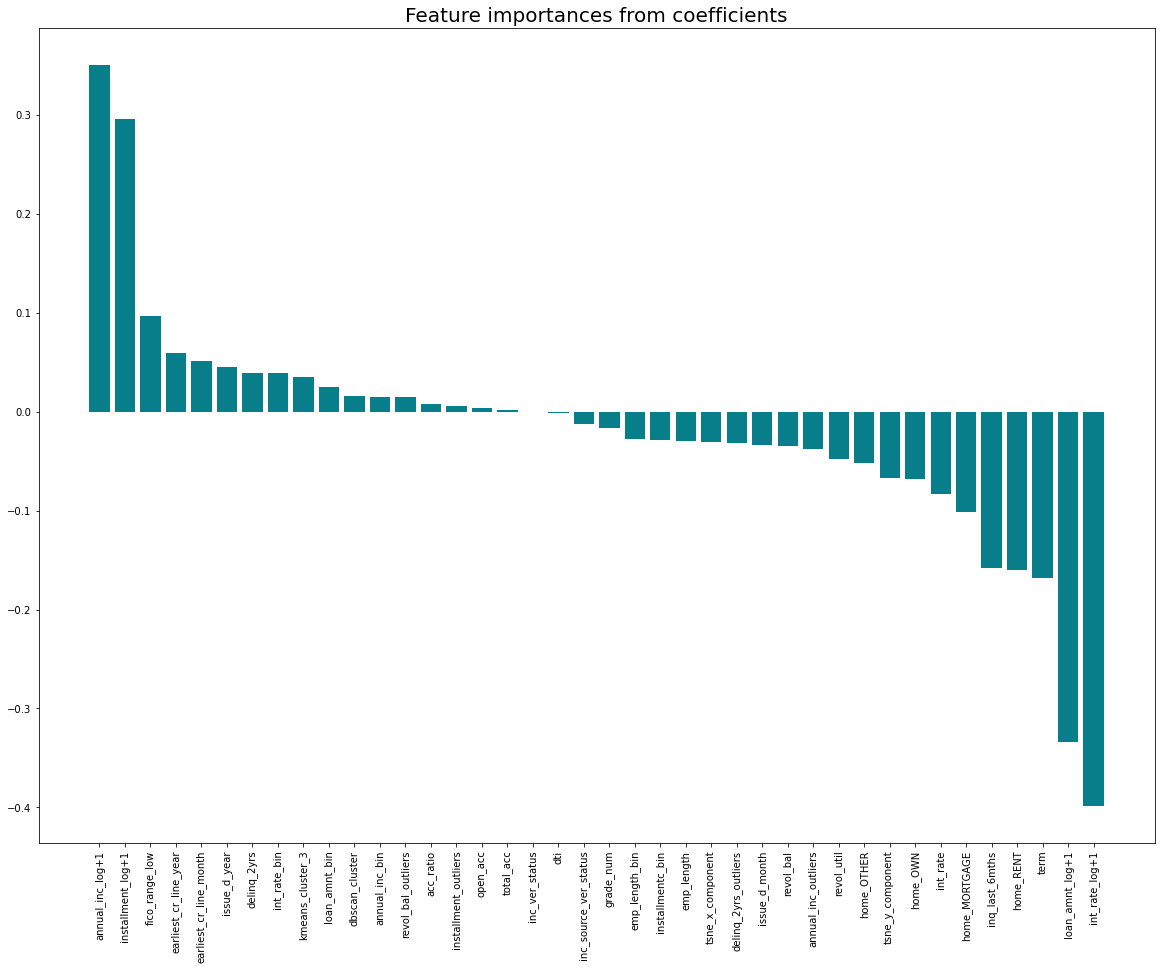

In [37]:
importances = pd.DataFrame(data={
    'Attribute': df_x.columns,
    'Importance': LogisticRegr_1.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20,15))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

Zmienne o zerowym/znikomym znaczeniu: open_acc, total_acc, inc_ver_status, dti

In [ ]:
# df_x = df_x.drop(columns=['annual_inc', 'pub_rec_bankruptcies', 'pub_rec_bankruptcies_outliers',  'pub_rec', 'loan_amnt_outliers',
#                         'annual_inc_outliers', 'delinq_2yrs', 'loan_amnt_bin'])

### 2. Random Forest

In [38]:
RandomForClass_2 = RandomForestClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    RandomForClass_2.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, RandomForClass_2.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_2 = np.mean(list_auroc_stratified) 
print('\nMean AUROC:', round((auroc_mean_2)*100, 3), '%')

List of aurocs: [0.6740862729530178, 0.6777244852176466, 0.6950926391137411, 0.6602762115657778, 0.6832473208987473, 0.6537141451170368, 0.6641568904834809, 0.6691862668604582, 0.6493161713038582, 0.6724449945890383]

Mean AUROC: 66.992 %


In [39]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'ROC AUC score': round(auroc_mean_2,3)},index=['2'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670


### 3. K-NN

Najpierw wybieram optymalne K - sprawdzam średni błąd dla K w zakresie od 1 do 30.

In [40]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=0, stratify = df_y)

In [45]:
knn_error=[]
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x,np.ravel(train_y))
    pred_i = knn.predict(test_x)
    knn_error.append(np.mean(pred_i != test_y.values)) 

Text(0, 0.5, 'Mean error')

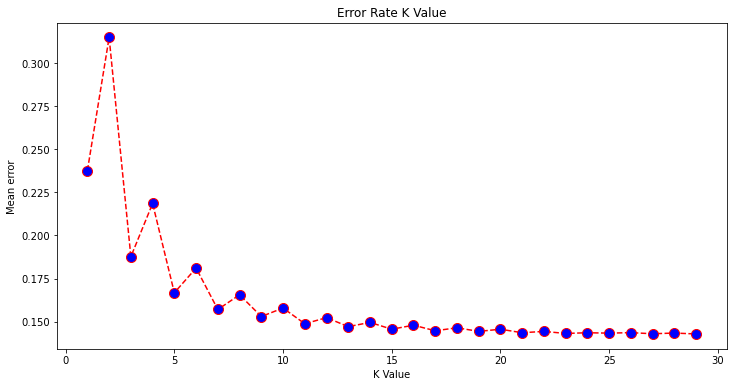

In [46]:
plt.figure(figsize=(12,6))
plt.plot(range(1,30), knn_error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean error')

In [47]:
# wybieram k = 15
KNN_3 = KNeighborsClassifier(n_neighbors=15)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    KNN_3.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, KNN_3.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_3 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_3)*100, 3), '%')

List of aurocs: [0.6259061285927249, 0.631133813431586, 0.6441300131706542, 0.6148550297631971, 0.6425405405964218, 0.5997876051119506, 0.6253936713723678, 0.6208883284032313, 0.6122023518681391, 0.6183780351668555]

Mean AUROC: 62.352 %


In [48]:
tempResultsDf = pd.DataFrame({'Method':['KNeighborsClassifier'], 'ROC AUC score': round(auroc_mean_3,3)},index=['3'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624


### 4. MLP

In [49]:
MLPmodel_4 = MLPClassifier(max_iter=1000)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    MLPmodel_4.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, MLPmodel_4.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_4 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_4)*100, 3), '%')

List of aurocs: [0.6401904472439838, 0.6423779750274475, 0.6602131495644588, 0.6342590008084342, 0.6422714932875152, 0.6208102536746538, 0.6363451164584752, 0.6641150091751088, 0.6325882079815432, 0.6163480843437845]

Mean AUROC: 63.895 %


In [50]:
tempResultsDf = pd.DataFrame({'Method':['MLPClassifier'], 'ROC AUC score': round(auroc_mean_4,3)},index=['4'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639


### 5. XGBoost

In [51]:
import xgboost as xgb
XGBmodel_5 = xgb.XGBClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    XGBmodel_5.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, XGBmodel_5.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_5 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_5)*100, 3), '%')

List of aurocs: [0.6854004747224755, 0.6716361591312744, 0.6937430089051817, 0.656348275926236, 0.6613565360146056, 0.6508582634999205, 0.6582847174071644, 0.6680358235132007, 0.6599343756091532, 0.6677814333438296]

Mean AUROC: 66.734 %


In [52]:
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'ROC AUC score': round(auroc_mean_5,3)},index=['5'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667


### 6. Light GBM Boost

In [53]:
import lightgbm as lgb
LGBMmodel_6 = lgb.LGBMClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_6.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_6.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_6 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_6)*100, 3), '%')

List of aurocs: [0.6936556525263051, 0.6855284078808893, 0.7173116565457323, 0.6695835426785016, 0.6861740180419352, 0.6599050761809653, 0.6827051395604118, 0.68555927316799, 0.6768138355160734, 0.6866357779091093]

Mean AUROC: 68.439 %


In [54]:
tempResultsDf = pd.DataFrame({'Method':['Light GBM'], 'ROC AUC score': round(auroc_mean_6,3)},index=['6'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684


# Modele na zbiorze PCA

In [55]:
df_x = pd.read_csv("Loan_data_no_outliers_x_stand_PCA.csv")

### Regresja Logistyczna - PCA

In [56]:
LogisticRegr_7 = LogisticRegression(max_iter=500)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LogisticRegr_7.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LogisticRegr_7.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_7 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_7)*100, 3), '%')

List of aurocs: [0.6998419314753821, 0.6894997632590443, 0.7251158376598001, 0.6799923912077097, 0.6921070151824353, 0.6575981441163153, 0.6861197588257102, 0.6863901776439645, 0.679669520283221, 0.684106353704712]

Mean AUROC: 68.804 %


In [57]:
tempResultsDf = pd.DataFrame({'Method':['Regresja logistyczna PCA'], 'ROC AUC score': round(auroc_mean_7,3)},index=['7'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688


### Random forest - PCA

In [58]:
RandomForClass_8 = RandomForestClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    RandomForClass_8.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, RandomForClass_8.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_8 = np.mean(list_auroc_stratified) 
print('\nMean AUROC:', round((auroc_mean_8)*100, 3), '%')

List of aurocs: [0.6665273616719494, 0.6759615921397868, 0.6944834705190314, 0.658658826302437, 0.6737598495609437, 0.633305834165545, 0.6706316890524845, 0.6651307601664291, 0.6439512274067146, 0.6692488302964213]

Mean AUROC: 66.517 %


In [59]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest PCA'], 'ROC AUC score': round(auroc_mean_8,3)},index=['8'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665


### KNN - PCA TUTAJ ZAKOŃCZYŁAM

In [60]:
KNN_9 = KNeighborsClassifier(n_neighbors=15)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    KNN_9.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, KNN_9.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_9 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_9)*100, 3), '%')

List of aurocs: [0.6366522554486604, 0.6399237259925028, 0.6397769259238585, 0.6122661278483865, 0.6462632662808513, 0.5842828816646715, 0.6328043362148708, 0.6299165941499567, 0.6004949750185752, 0.610975901701984]

Mean AUROC: 62.334 %


In [61]:
tempResultsDf = pd.DataFrame({'Method':['KNN PCA'], 'ROC AUC score': round(auroc_mean_9,3)},index=['9'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623


### MLP - PCA

In [62]:
MLPmodel_10 = MLPClassifier(max_iter=1000)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    MLPmodel_10.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, MLPmodel_10.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_10 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_10)*100, 3), '%')

List of aurocs: [0.6637663315076368, 0.6720693227141059, 0.648872844261668, 0.6375738910908899, 0.673625713582728, 0.6205399141116218, 0.6433284368396261, 0.649281787266738, 0.6166769301724837, 0.6260836788541274]

Mean AUROC: 64.518 %


In [63]:
tempResultsDf = pd.DataFrame({'Method':['MLP PCA'], 'ROC AUC score': round(auroc_mean_10,3)},index=['10'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623
10,MLP PCA,0.645


### XGBoost - PCA

In [64]:
XGBmodel_11 = xgb.XGBClassifier(random_state=1)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    XGBmodel_11.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, XGBmodel_11.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_11 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_11)*100, 3), '%')

List of aurocs: [0.660504165193497, 0.6740997123959218, 0.6724515714843968, 0.6400162513878809, 0.658282780351948, 0.6305261955418267, 0.6514474645521259, 0.6596399138175744, 0.6493857149578834, 0.6550174583009529]

Mean AUROC: 65.514 %


In [65]:
tempResultsDf = pd.DataFrame({'Method':['XGBClassifier PCA'], 'ROC AUC score': round(auroc_mean_11,3)},index=['11'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623
10,MLP PCA,0.645


### Light GBM - PCA

In [66]:
LGBMmodel_12 = lgb.LGBMClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_12.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_12.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_12 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_12)*100, 3), '%')

List of aurocs: [0.6961388480536586, 0.6871809424564408, 0.7147674666236605, 0.6624471984964365, 0.6829382137119535, 0.6502855364715466, 0.6749276254797607, 0.6779192952358203, 0.6676102887380128, 0.6786049077654668]

Mean AUROC: 67.928 %


In [67]:
tempResultsDf = pd.DataFrame({'Method':['LGBMClassifier PCA'], 'ROC AUC score': round(auroc_mean_12,3)},index=['12'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623
10,MLP PCA,0.645


Podsumowując działanie modeli na danych po PCA - w żadnym modelu poprawa metryki AUC ROC nie była wyraźna.

Modele, które odniosły lepszy rezultat przy PCA: MLP

Modele, które uzyskały niższy wynik: XGBoost, Light GBM

Porównywalny: regresja logistyczna, random forest, KNN

Najlepszy wynik osiągnęłam przy regresji logistycznej oraz Light GBM.

##  Optymalizacja

In [70]:
df_x = pd.read_csv('Loan_data_x_after_unsupervised.csv')
df_x = df_x[predictors_log]

In [ ]:
# usuwam zmienne o znikomej istotności dla modelu
df_x = df_x.drop(columns=['open_acc', 'total_acc', 'inc_ver_status', 'dti'])

### Regresja logistyczna

In [76]:
# sprawdzenie modelu na innym zastawie predyktorów
LogisticRegr_13 = LogisticRegression(max_iter=500)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LogisticRegr_13.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LogisticRegr_13.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_13 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_13)*100, 3), '%')

List of aurocs: [0.7035124500931457, 0.692603757668236, 0.7224677505060467, 0.6782576692697835, 0.6954213885632409, 0.6599810607235383, 0.6825996607096969, 0.6847526701919353, 0.6845618775649069, 0.6875597519592438]

Mean AUROC: 68.917 %


In [77]:
tempResultsDf = pd.DataFrame({'Method':['Reg Log - predictors log 2 '], 'ROC AUC score': round(auroc_mean_13,3)},index=['13'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623
10,MLP PCA,0.645


Wynik na innym zestawie predyktorów oraz po usunięciu nieistotnych zmiennych nie zmienił się.

### GridSearch

In [81]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, random_state=0, stratify = df_y)

LogisticRegr_14 = LogisticRegression(max_iter=500, random_state=1)
grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # 'penalty': ['l2'], # tego nie ustawiam, ponieważ jest to wartość domyślna. nie zmieniam 
    'C':  [100, 10, 1.0, 0.1, 0.01]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LogisticRegr_14, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(train_x, np.ravel(train_y))

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print(f"{mean} with:{param}")

Best: 0.6872492077273772 using {'C': 0.01, 'solver': 'liblinear'}
0.687112 (0.013838) with: {'C': 100, 'solver': 'newton-cg'}
0.687107 (0.013838) with: {'C': 100, 'solver': 'lbfgs'}
0.687111 (0.013837) with: {'C': 100, 'solver': 'liblinear'}
0.687111 (0.013839) with: {'C': 100, 'solver': 'sag'}
0.687110 (0.013838) with: {'C': 100, 'solver': 'saga'}
0.687111 (0.013838) with: {'C': 10, 'solver': 'newton-cg'}
0.687108 (0.013837) with: {'C': 10, 'solver': 'lbfgs'}
0.687112 (0.013839) with: {'C': 10, 'solver': 'liblinear'}
0.687111 (0.013837) with: {'C': 10, 'solver': 'sag'}
0.687110 (0.013837) with: {'C': 10, 'solver': 'saga'}
0.687119 (0.013831) with: {'C': 1.0, 'solver': 'newton-cg'}
0.687115 (0.013830) with: {'C': 1.0, 'solver': 'lbfgs'}
0.687121 (0.013835) with: {'C': 1.0, 'solver': 'liblinear'}
0.687118 (0.013831) with: {'C': 1.0, 'solver': 'sag'}
0.687119 (0.013831) with: {'C': 1.0, 'solver': 'saga'}
0.687153 (0.013839) with: {'C': 0.1, 'solver': 'newton-cg'}
0.687152 (0.013838) with

Nie widać zauważalnej różnicy pomiędzy różnymi ustawieniami parametrów. 

Drugi w kolejności model pod względem AUC ROC score to był Light GBM - spróbuję więc jeszcze jego optymalizacji.

### Light GBM

In [90]:
df_x = pd.read_csv('Loan_data_x_after_unsupervised.csv')
df_x = df_x[predictors_log]

In [91]:
df_x = df_x.drop(columns=['open_acc', 'total_acc', 'inc_ver_status', 'dti'])

In [92]:
# uruchamiam najpierw model na zmienionym zestawie predyktorów
import lightgbm as lgb
LGBMmodel_15 = lgb.LGBMClassifier(random_state = 0)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_15.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_15.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_15 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_15)*100, 3), '%')

List of aurocs: [0.7036158304231771, 0.691212775327664, 0.7249793756241587, 0.6684122435392463, 0.6992030410357882, 0.6575826370668106, 0.6787651942542982, 0.6866419825473866, 0.6792362297101865, 0.6861978338573668]

Mean AUROC: 68.758 %


Wyniki na pozostałych zestawach predyktorów: 
- Na predyktorach oryginalnych predictors_orig - 68,54%
- logarytmicznych predictors_log - 68,439%
- kategoryzowanych predictors_cat -  68,601%
- logarytmicznych bez najmniej istotnych zmiennych - 68,758%

In [106]:
tempResultsDf = pd.DataFrame({'Method':['Light GBM - predictors log '], 'ROC AUC score': round(auroc_mean_15,3)},index=['15'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623
10,MLP PCA,0.645


In [100]:
# trenuję model jeszcze raz w uproszczony sposób, aby wyświetlić feature importances
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, random_state=0, stratify = df_y['target'])
LGBMmodel_15.fit(train_x, np.ravel(train_y))

LGBMClassifier(random_state=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

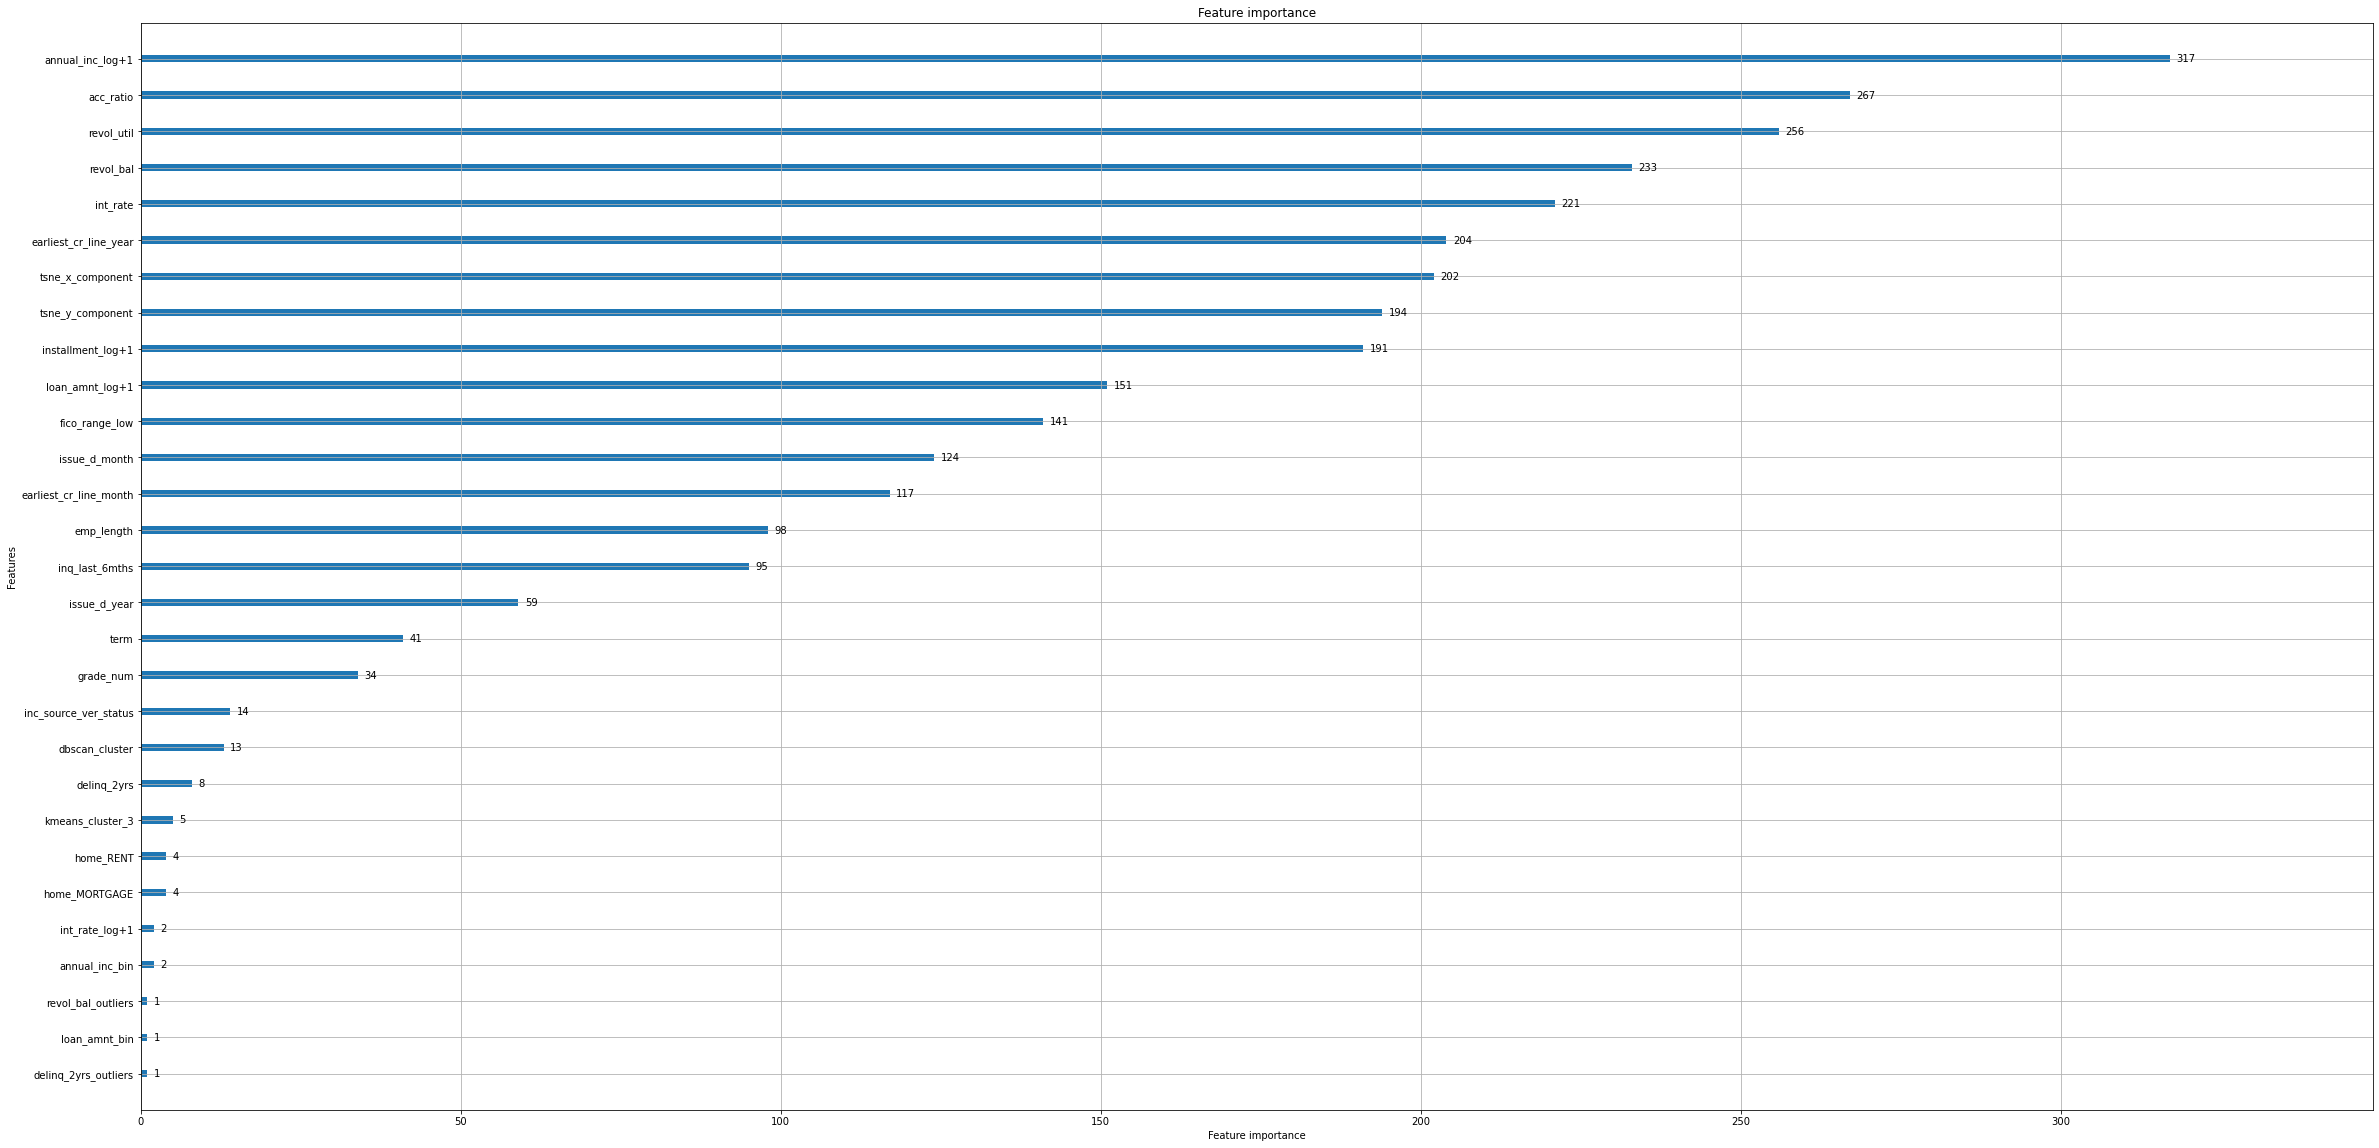

In [98]:
lgb.plot_importance(LGBMmodel_15, figsize=(40,20))

Z wykresu feature importances wynika, że najmniejsze znaczenie dla modelu posiadają zmienne: revol_bal_outliers, loan_amnt_bin oraz delinq_2yrs_outliers. Usuwam je więc z zestawu predyktorów.

In [101]:
df_x = df_x.drop(columns=['revol_bal_outliers', 'loan_amnt_bin', 'delinq_2yrs_outliers'])

In [102]:
# powtarzam operację powyżej
for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]    
    LGBMmodel_15.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_15.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_15 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_15)*100, 3), '%')

List of aurocs: [0.7036158304231771, 0.691212775327664, 0.7249793756241587, 0.6684122435392463, 0.6992030410357882, 0.6575826370668106, 0.6787651942542982, 0.6866419825473866, 0.6792362297101865, 0.6861978338573668]

Mean AUROC: 68.758 %


In [107]:
tempResultsDf = pd.DataFrame({'Method':['Light GBM - less features '], 'ROC AUC score': round(auroc_mean_15,3)},index=['15'])
results = pd.concat([results, tempResultsDf])
results

,Method,ROC AUC score
1,Log Reg StratifiedKFold,0.689
2,Random Forest,0.670
3,KNeighborsClassifier,0.624
4,MLPClassifier,0.639
5,XGBoost,0.667
6,Light GBM,0.684
7,Regresja logistyczna PCA,0.688
8,Random Forest PCA,0.665
9,KNN PCA,0.623
10,MLP PCA,0.645


Wynik pozostał taki sam.


### Light GBM Grid Search

Manipuluję parametrami, jednak ze względu na czas obliczeniowy dzielę to na dwie tury, pozostawiając częśc parametrów stałych.

dla parametrów:
  - 'num_leaves' default = 31
  - 'max_depth': [-1, 5, 10],
  - 'min_child_samples': [20, 40, 60, 80, 100],
  - 'max_bin' default = 255
  - 'boosting_type': ['dart', 'gbdt', 'goss'],
  - 'learning_rate' default = 0.1

Najlepszy wynik:

Best: 0.6892187140351865 using {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 100}

In [108]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, random_state=0, stratify = df_y)
LGBMmodel_16 = lgb.LGBMClassifier(random_state = 0)

grid = {
    'max_depth': [5],
    'min_child_samples': [100, 120, 140, 200],
    'boosting_type': ['dart'],
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=LGBMmodel_16, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(train_x, np.ravel(train_y))

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))    

Best: 0.6880602825428608 using {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 100}
0.688060 (0.015034) with: {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 100}
0.687497 (0.014981) with: {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 120}
0.687264 (0.014497) with: {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 140}
0.687983 (0.015007) with: {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 200}


Ustawiam więc 'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 100

Następna część hiperparametrów:

przy tych parametrach:
- 'num_leaves': [50, 70, 90, 110], # less then 2^max_depth, default 31, large may cause overfitting
- 'max_bin': [200, 350, 500], # default is 255, larger for better accuracy
- 'learning_rate': [0.01, 0.05, 0.1, 0.3] # small for better accuracy, default 0.1

Best: 0.68876 using {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 50}

przy kolejnych:
- 'num_leaves': [20, 31, 50, 70], # less then 2^max_depth, default 31, large may cause overfitting
- 'max_bin': [150, 200, 350], # default is 255, larger for better accuracy
- 'learning_rate': [0.05, 0.1] # small for better accuracy, default 0.1

Best: 0.6895239010483522 using {'learning_rate': 0.1, 'max_bin': 350, 'num_leaves': 20}

przy kolejnych:
- 'num_leaves': [8, 9, 10, 15, 20, 31], # less then 2^max_depth, default 31, large may cause overfitting
- 'max_bin': [200, 350, 400, 450], # default is 255, larger for better accuracy
- 'learning_rate': [0.1] # small for better accuracy, default 0.1

Best: 0.6904702388372592 using {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 10}

In [109]:
LGBMmodel_17 = lgb.LGBMClassifier(random_state = 0, boosting_type='dart', max_depth = 5, min_child_samples = 100)

grid = {    
    'num_leaves': [8, 9, 10],
    'max_bin': [200],
    'learning_rate': [0.1]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=LGBMmodel_17, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(train_x, np.ravel(train_y))
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.690011558209325 using {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 10}
0.689344 (0.015452) with: {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 8}
0.689711 (0.015276) with: {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 9}
0.690012 (0.015336) with: {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 10}


Wybieram więc ostateczne hiperparametry i trenuję z nimi model raz jeszcze.

In [110]:
LGBMmodel_18 = lgb.LGBMClassifier(
    random_state = 0,
     num_leaves = 10,
     max_depth = 5,
     min_child_samples = 100,
     max_bin = 200,
     boosting_type = 'dart',
     learning_rate = 0.1
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_18.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_18.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_18 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_18)*100, 3), '%')

List of aurocs: [0.7058020659525154, 0.6904332876392274, 0.7224310504888856, 0.6764717740684916, 0.6925830816022296, 0.6619295214938045, 0.6810937432944665, 0.6887091612001218, 0.6791188586361068, 0.6883350732173169]

Mean AUROC: 68.869 %


To jest mój ostateczny model z wynikiem 68,869% - jak widać optymalizacja hiperparametrów nie poprawiła wyniku wyraźnie. Jest to prawdopodobnie maksimum, które można otrzymac przy danym zbiorze.